# Exercise 1 - code

    Anna Braghetto - 1205200, Davide Maniscalco - 1212063

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats, optimize
import math as ma
from sympy.utilities.iterables import multiset_permutations
import networkx as nx
import scipy

In [2]:
import sys

In [3]:
np.random.seed(1234)

# Reading the data

In [4]:
data = pd.read_csv('bci05.csv')
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


#### Just the relevant informations are kept.

In [5]:
data=data[data['status']=='A']
data=data.drop(columns=['tag', 'dbh', 'pom', 'date', 'codes','status'])
data.index=np.arange(len(data))
data.head()

,sp,gx,gy
0,ACACME,610.0,104.7
1,ACACME,534.8,241.3
2,ACACME,282.7,177.5
3,ACACME,84.2,74.8
4,ACACME,149.9,389.8


# Task 1

Extract the information you need from the raw data. 

The number of species is 299


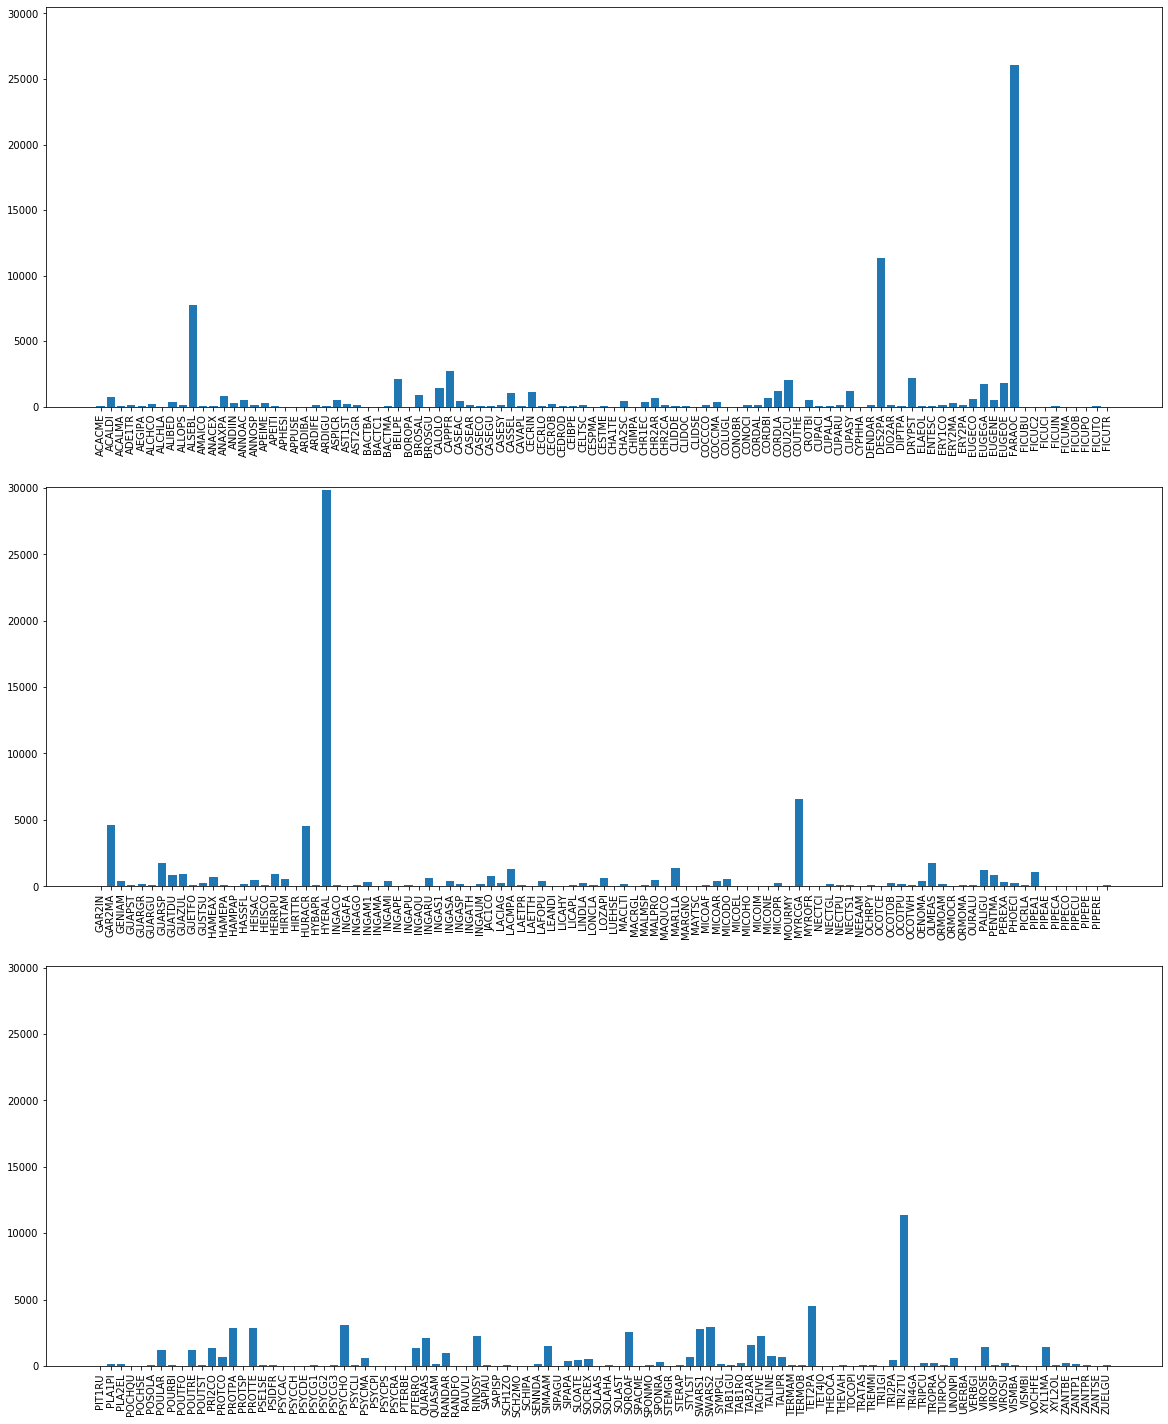

In [6]:
species=data.groupby(['sp']).size()

m=int(len(species)/3)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,25))
ax1.bar(np.arange(m), species.values[0:m].reshape(m,))
ax1.set_xticks(np.arange(m))
ax1.set_xticklabels(list(species.index[0:m]),rotation=90)
ax1.set_ylim(top=30500)
ax2.bar(np.arange(m), species.values[m:2*m].reshape(m,))
ax2.set_xticks(np.arange(m))
ax2.set_xticklabels(list(species.index[m+1:2*m]),rotation=90)
ax2.set_ylim(top=30100)
ax3.bar(np.arange(m+1), species.values[2*m+1:].reshape(m+1,))
ax3.set_xticks(np.arange(m+1))
ax3.set_xticklabels(list(species.index[2*m+1:]),rotation=90)
ax3.set_ylim(top=30100);

print('The number of species is', len(species))

#list(species.index[0:m])

# Task 2

In [7]:
#just to plot

num=[]
for j in range(len(data)-1):
    if data.loc[data.index[j],'sp'] != data.loc[data.index[j+1],'sp']: 
        num.append(data.index[j])
        j+=1
num.append(data.index[-1])
col=np.repeat(1/len(species),num[0]+1)
i=1
while i<len(species): 
    col=np.hstack((col,np.repeat((i+1)/len(species),num[i]-num[i-1])))
    i +=1

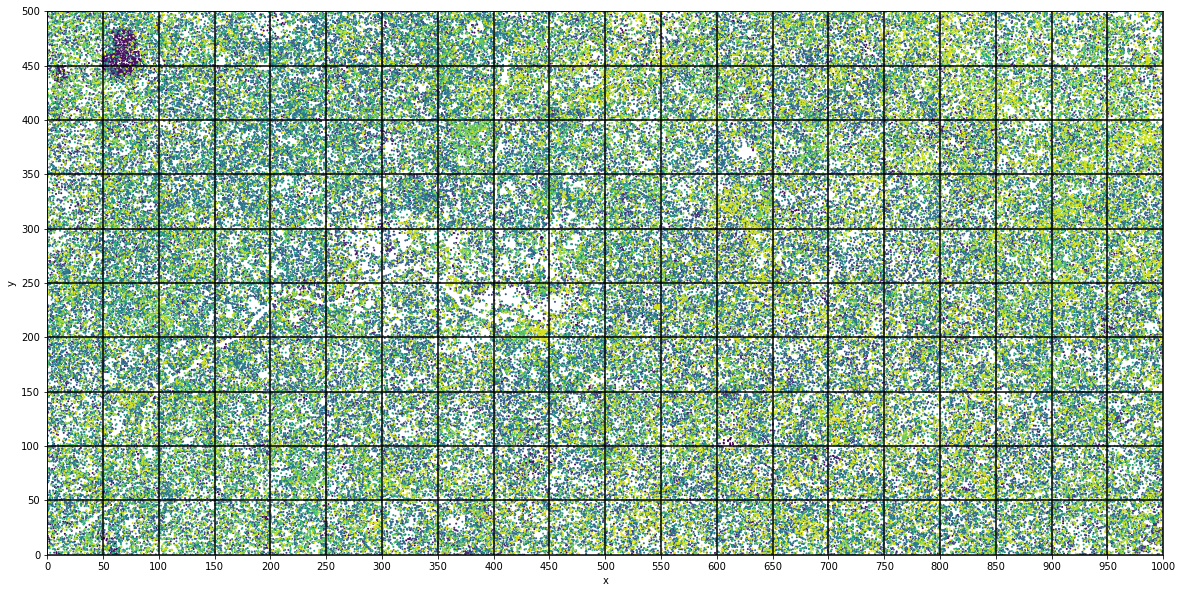

In [8]:
fig, ax=plt.subplots(figsize=(20,10))
ax.set_xticks([x for x in range(0,1050,50)])
ax.set_yticks([y for y in range(0,550,50)])
ax.set_xlim([0, 1000])
ax.set_ylim([0, 500])
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(data['gx'],data['gy'], c=col, cmap='viridis', s=1, alpha=10);

In [8]:
#dividing the area
data['sub']=np.zeros(len(data))

x=[x for x in range(0,1050,50)]
y=[y for y in range(0,550,50)]

l=0
for j in range(len(y)-1):
    for i in range(len(x)-1): 
        data['sub'][(data['gx']>x[i]) & (data['gx']<x[i+1]) & (data['gy']>y[j]) & (data['gy']<y[j+1])]= l
        l +=1    

/home/davide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


### The vector of the abundances for all the species $(x_1,...,x_S)$ for each subplot

In [9]:
#dataframe with counts per subplots
sub=data.groupby(['sub','sp']).size()

#abundance matrix
abun=pd.DataFrame(np.zeros((299,200)), columns=np.arange(200), index=species.index)

for i in range(200):
    abun[i] += sub[i]
#replace NaN with 0
abun=abun.fillna(0)

print('The abundance matrix is')
abun

The abundance matrix is


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
sp,,,,,,,,,,,,,,,,,,,,,
ACACME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACALDI,28.0,16.0,5.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,...,4.0,1.0,10.0,2.0,2.0,0.0,3.0,18.0,5.0,6.0
ACALMA,9.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADE1TR,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,10.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0
AEGIPA,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALCHCO,1.0,0.0,0.0,1.0,6.0,4.0,0.0,2.0,0.0,1.0,...,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0
ALCHLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALIBED,3.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,2.0,3.0,1.0,1.0,2.0
ALLOPS,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


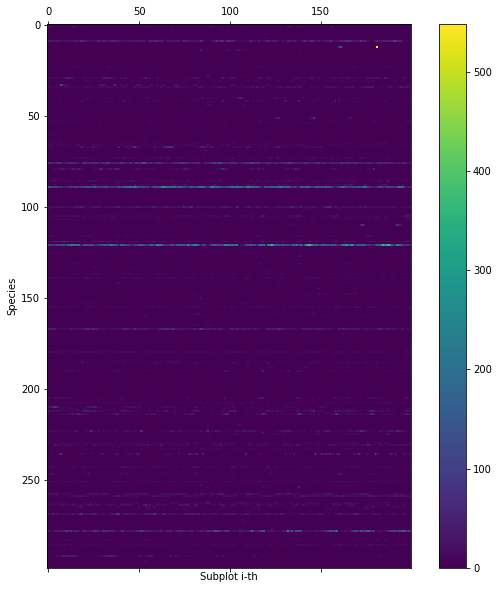

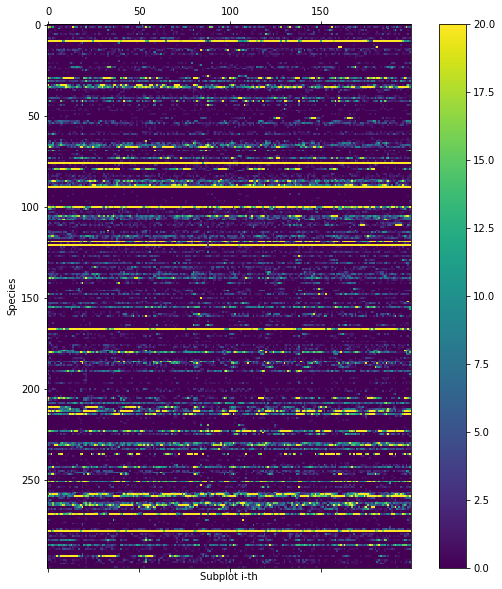

In [10]:
#plot the abundance matrix

fig, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel('Subplot i-th')
ax1.set_ylabel('Species')
#ax1.set_title('Abundance Matrix')
pax1=ax1.matshow(abun)
fig.colorbar(pax1)


fig, ax2 = plt.subplots(figsize=(10,10))
ax2.set_xlabel('Subplot i-th')
ax2.set_ylabel('Species')
#ax2.set_title('Abundance Matrix with Cut')
pax2=ax2.matshow(abun, vmax=20)
fig.colorbar(pax2)

plt.show();


### The average “presence” $p_i$ of each species (i=1,..,S) averaged over the N subplots

In [11]:
#average presence
temp = abun.copy()
temp[temp>0]=1
pi = temp.mean(axis=1)
print('The average presence is')
pi

The average presence is


sp
ACACME    0.050
ACALDI    0.765
ACALMA    0.080
ADE1TR    0.275
AEGIPA    0.180
ALCHCO    0.515
ALCHLA    0.010
ALIBED    0.705
ALLOPS    0.340
ALSEBL    1.000
AMAICO    0.040
ANACEX    0.115
ANAXPA    0.020
ANDIIN    0.720
ANNOAC    0.720
ANNOSP    0.335
APEIME    0.690
APEITI    0.170
APHESI    0.030
APPUSE    0.005
ARDIBA    0.010
ARDIFE    0.280
ARDIGU    0.035
ASPICR    0.670
AST1ST    0.505
AST2GR    0.215
BACTBA    0.025
BACTC1    0.010
BACTMA    0.070
BEILPE    0.860
          ...  
TET2PA    1.000
TET4JO    0.025
THEOCA    0.085
THEVAH    0.105
TOCOPI    0.035
TRATAS    0.220
TREMMI    0.115
TRI1GI    0.010
TRI2PA    0.790
TRI2TU    1.000
TRI4GA    0.005
TRIPCU    0.480
TROPRA    0.650
TURPOC    0.240
UNONPI    0.690
URERBA    0.040
VERBGI    0.005
VIROSE    0.930
VIROSP    0.160
VIROSU    0.475
VISMBA    0.100
VISMBI    0.015
VOCHFE    0.065
XYL1MA    0.695
XYL2OL    0.210
ZANTBE    0.455
ZANTP1    0.435
ZANTPR    0.285
ZANTSE    0.005
ZUELGU    0.140
Length: 299, dtype: f

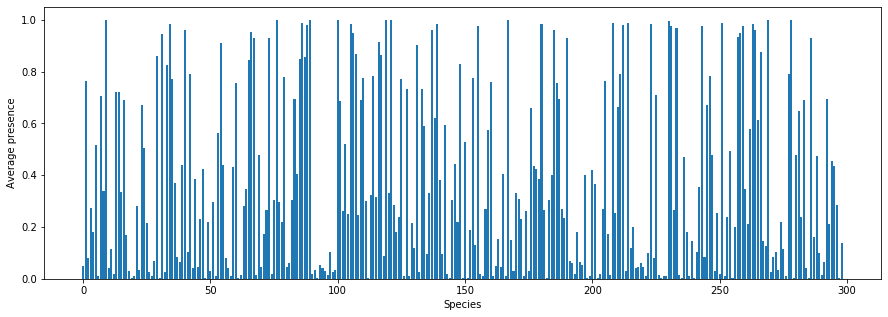

In [12]:
#plot of the average presence pi

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(pi.shape[0]), pi.values.reshape(pi.shape[0],))
ax.set_xlabel('Species')
ax.set_ylabel('Average presence');

# Task 3

For species i, the probability $P_i$ is $$P_i=\frac{1}{Z}e^{\sigma_i\lambda_i}$$
where Z is the partition function $Z=\sum_{\sigma_{i}} e^{-\sigma_i\lambda_i}$. 

Since $\sigma_i = \pm 1$, the partition function becomes
$$Z=e^{-\lambda_i}+e^{\lambda_i}=2\cosh(\lambda_i)$$


By imposing $$\langle \sigma_i \rangle_{emp} =\langle \sigma_i \rangle_{mod} = \frac{1}{Z}\frac{\partial Z}{\partial \lambda_i}= \frac{\sinh (\lambda_i)}{\cosh(\lambda_i)}=\tanh(\lambda_i)$$

it is possible to compute the $i$-th Lagrangian parameter

$$\lambda_i = \tanh^{-1} \left(\langle \sigma_i \rangle_{emp} \right) $$

From the constraints
\begin{equation}
\begin{cases}
\frac{1+m_i}{2}=p_i\\
\langle\sigma_i\rangle=m_i
\end{cases}
\end{equation}

$\langle \sigma_i \rangle_{emp}= m_i = 2p_i -1$ where $p_i$ is the average presence.

In [13]:
#computation of lambda_i
#vector m
mi=2*pi-1
mi.head()

sp
ACACME   -0.90
ACALDI    0.53
ACALMA   -0.84
ADE1TR   -0.45
AEGIPA   -0.64
dtype: float64

In [14]:
#vector lambda
l=pd.DataFrame(np.arctanh(mi).values, columns=['Lambda'], index=species.index)
l=l.fillna(ma.inf)

print('The Lagrangian parameters are')
l.T

The Lagrangian parameters are


/home/davide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  


sp,ACACME,ACALDI,ACALMA,ADE1TR,AEGIPA,ALCHCO,ALCHLA,ALIBED,ALLOPS,ALSEBL,...,VISMBA,VISMBI,VOCHFE,XYL1MA,XYL2OL,ZANTBE,ZANTP1,ZANTPR,ZANTSE,ZUELGU
Lambda,-1.472219,0.590145,-1.221174,-0.4847,-0.758174,0.030009,-2.29756,0.435611,-0.331647,inf,...,-1.098612,-2.092296,-1.33308,0.4118,-0.662463,-0.090244,-0.13074,-0.459897,-2.646652,-0.907645


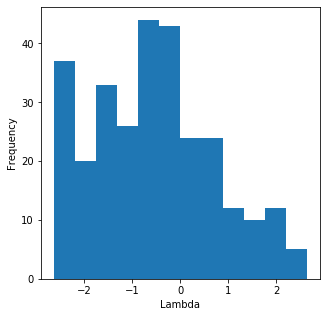

In [15]:
#plot
lplot = l[l != ma.inf].dropna()
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(lplot.values,12,histtype='stepfilled')
ax.set_xlabel('Lambda')
ax.set_ylabel('Frequency');

In [18]:
meanL = np.mean(lplot.values)
stdL = np.std(lplot.values)

print('Mean:',meanL)     #mean of previous lambdas ignoring infinite values
print('Standard Deviation:',stdL) 

Mean: -0.5617402900400296
Standard Deviation: 1.276808171142704


# Task 4

Given the hamiltonian
$$H=-\sum_{j=1}^S \lambda_j \sigma_j -\frac{K}{S}\left(\sum_{j=1}^s \sigma_j\right)^2$$
the probability P is
$$P=\frac{e^{\sum_{j=1}^S \lambda_j \sigma_j +\frac{K}{S}\left(\sum_{h=1}^s \sigma_j\right)^2}}{\sum_{\sigma}e^{\sum_{j=1}^S \lambda_j \sigma_j +\frac{K}{S}\left(\sum_{h=1}^s \sigma_j\right)^2}}$$


In order to compute the Lagrangian parameters the metropolis algorithm is emplemented.




In [19]:
#EMPIRICAL VALUES
#number of species
S=299

#<sigma_i>emp
sigma_emp = mi.values.reshape(299,)


#(sum sigma_j)^2

#Sp = number of present species 
Sp=temp.sum(axis=0).values
#Sm = number of absent species
Sm=S-temp.sum(axis=0).values
#(sum sigma_j)^2
sigma2_emp = ((Sp-Sm)**2).mean()

#### Function definitions

In [16]:
def Energy(RandomState, L, K):
    return -np.sum(L*RandomState)-(K/S)*(np.sum(RandomState)**2)

def DeltaEnergy(RandomState, index, L, K):
    return -2*L[index]*RandomState[index] + 4*(K/S)*RandomState[index]*(RandomState[index]-sum(RandomState))

def Metropolis(L, K, samples, therm):
    
    iterations=samples+therm
    
    #Generate random configuration        
    RandomState = 2*np.random.randint(0,2,S)-1
    
    #energy of the random state
    E = np.zeros(iterations+1)   
    E[0] = Energy(RandomState, L, K)
    
    
    #dataframe to save the configurations 
    States=pd.DataFrame(index=np.arange(S))  
    
    for i in range(therm+samples):
        
        #select a random spin
        index=np.random.randint(0, S)
        #random  spin flip 
        RandomState[index]*=-1       
        
        #Delta E
        dE=DeltaEnergy(RandomState, index, L, K)
        #probability to accept 
        p=min([1,np.exp(-dE)])
        
        
        r=np.random.uniform(0,1) 
        if r<p: #always verify if dE<0
            E[i+1]=E[i]+dE
        else:
            RandomState[index] *= -1   #go back to previous configuration  -> spin flip not good  
            E[i+1]=E[i]
                
                
        #after "thermalization" steps -> computing the mod values
        if i>therm:
            States[str(i)]=RandomState    
            
            
        #compute model values
        sigma_mod =  States.mean(axis=1)
        sigma2_mod =  (States.sum(axis=0)**2).mean()/States.shape[0]    
        
    return sigma_mod , sigma2_mod, E   

def GradientDescent(V, eta, empirical, model):
    return V + eta*(empirical-model)

In [20]:
def Simulations(Linit, Kinit,sigma_emp, sigma2_emp, eta, itGD, itSamples, itTherm, Verbose):
    
    #initialization
    L=Linit
    K=Kinit
    
    #array for K and L for each iteration of GD
    KL = np.zeros((itGD,300))
    #array for Energy for each iteration of GD and Metropolis
    ENERGY = np.zeros((itGD, itSamples+itTherm+1))
    
    for i in range(itGD):
        
        #recall Metropolis
        sigma_mod, sigma2_mod, E = Metropolis(L, K, itSamples, itTherm)
        
        #store the values
        KL[i,0] = K
        KL[i,1:] = L
        ENERGY[i,:] = E
        
        #update
        L = GradientDescent(L, eta, sigma_emp, sigma_mod)
        K = GradientDescent(K, eta/S, sigma2_emp/S, sigma2_mod)
        #L += eta*(sigma_emp-sigma_mod)
        #K += eta*(sigma2_emp-sigma2_mod)/S**2
        
        if Verbose==True:
            if (i%10)==0:
                print('Iteration:',i, '\n','K =', K,'\n', 'Empirical <(Σσ)^2>=',sigma2_emp/S,'\n','Model <(Σσ)^2>=',sigma2_mod,'\n')
           
        
    return KL, ENERGY     

#### Simulations

At first we check the convergence of the Metropolis Algorithm

In [21]:
#random initialization for L and K
Ltrial=np.random.normal(meanL, stdL, S) 
Ktrial = np.random.rand()
#recall the algorithm
_, _, Econv1 = Metropolis(Ltrial, Ktrial, 0, therm=10000)
_, _, Econv2 = Metropolis(Ltrial, Ktrial, 0, therm=100000)

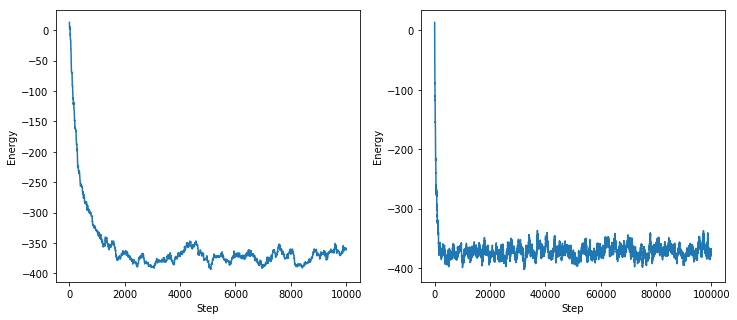

In [22]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.plot(Econv1)
ax1.set_xlabel('Step')
ax1.set_ylabel('Energy')
ax2.plot(Econv2)
ax2.set_xlabel('Step')
ax2.set_ylabel('Energy');

#### Eta = 0.5

In [21]:
#parameters

Linit=np.random.normal(meanL, stdL, S) 
Kinit = 1.5
eta=0.5
itGD=5000
itSamples=500
itTherm=2000
Verbose= True

In [42]:
#running Metropolis and GD

KL, ENERGY = Simulations(Linit, Kinit,sigma_emp, sigma2_emp, eta, itGD, itSamples, itTherm, Verbose)
KL = pd.DataFrame(KL)
ENERGY = pd.DataFrame(ENERGY)
KL.to_csv('KLeta05.csv',index=None)
ENERGY.to_csv('ENERGYeta05.csv',index=None)

Iteration: 0 
 K = 1.074137067997361 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 276.01666878908316 

Iteration: 10 
 K = 0.7220449978154541 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 23.691443086842582 

Iteration: 20 
 K = 0.7045823883424168 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 26.95887427027969 

Iteration: 30 
 K = 0.7198727043240966 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 17.307089094577112 

Iteration: 40 
 K = 0.7381589563619585 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 16.7336344930664 

Iteration: 50 
 K = 0.7620742111733229 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 17.30489071789063 

Iteration: 60 
 K = 0.7518384131267426 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 17.546980248121663 

Iteration: 70 
 K = 0.7206693491231859 
 Empirical <(Σσ)^2>= 21.350635451505017 
 Model <(Σσ)^2>= 21.818908720450935 

Iteration: 80 
 K = 0.7407874322934749 
 Empirical <(Σ

In [22]:
#read the results
KLin = pd.read_csv('KLeta05.csv')
ENERGYin = pd.read_csv('ENERGYeta05.csv')

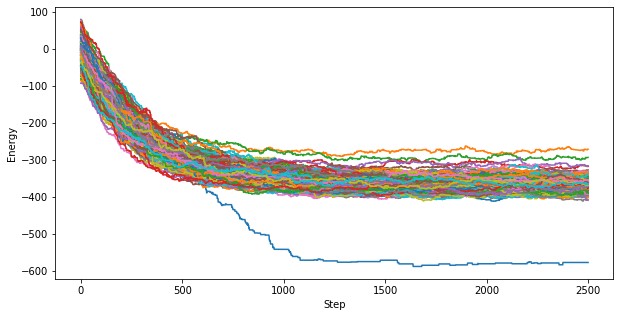

In [65]:
#energy plot
fig, ax = plt.subplots(figsize=(10,5))
for i in range(0,itGD, 10):  
    ax.plot(ENERGYin.values[i,:])
ax.set_xlabel('Step')
ax.set_ylabel('Energy');

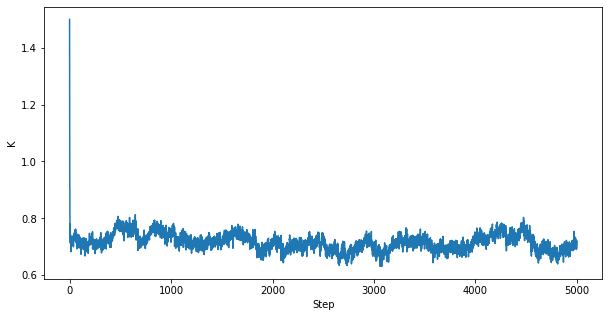

In [66]:
#evoluzione del k
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(KLin.values[:,0])
ax.set_xlabel('Step')
ax.set_ylabel('K');

In [67]:
#final k
n=2500
Kfin = np.mean(KLin.values[itGD-n:,0])
ErrorKfin = np.std(KLin.values[itGD-n:,0])
print('Final K is:', Kfin)
print('The error associated to final K is:', ErrorKfin)

Final K is: 0.7064252504606515
The error associated to final K is: 0.027751817831821804


In [24]:
#final lambdas

n=2500
Lfin = KLin.copy()
Lfin = Lfin.drop(['0'], axis=1)
Lfin = np.mean(Lfin.values[itGD-n:,:], axis=0)

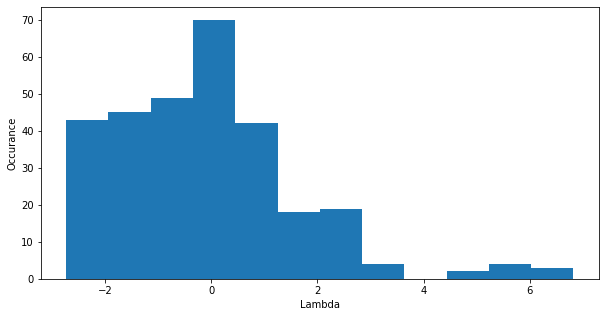

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(Lfin, bins=12)
ax.set_xlabel('Lambda')
ax.set_ylabel('Occurance');

# Task 6

From max entropy principle the probability is 
$$P(x)=\frac{1}{Z}e^{-\lambda^T\cdot x - \frac{1}{2}x^TMX}$$
where Z is the partition function 
$$Z=\frac{(2\pi)^{-S/2}}{|M|^{1/2}}e^{-\frac{1}{2}\lambda^T M\lambda}$$


From the contraints
\begin{equation}
\begin{cases}
\langle x_i\rangle_{emp}=\langle x_i\rangle_{mod}\\
\langle x_ix_j\rangle_{emp}=\langle x_ix_j\rangle_{mod}
\end{cases}
\end{equation}


From the model:

$\rightarrow \langle x_i\rangle_{emp}=\langle x_i\rangle_{mod}=-\frac{1}{Z}\frac{\partial Z}{\partial \lambda_i} =\frac{\partial }{\partial \lambda_i}\left(-\frac{\lambda^TM\lambda}{2}\right)=-\sum_j M_{ij}^{-1}\lambda_i$

$\rightarrow \frac{\partial^2 ln(Z) }{\partial \lambda_i\lambda_j} = \langle x_ix_j\rangle_{p}-\langle x_i\rangle_{p}\langle x_j\rangle_{p}=\langle x_i -\langle x_i\rangle_{p}\rangle_{p}\langle x_j-\langle x_j\rangle_{p}\rangle_{p}=\text{Cov}(x_ix_j)=M_{ij}^{-1}$

\begin{equation}
\longrightarrow
\begin{cases}
\langle x_i\rangle_{emp}=-\sum_j M_{ij}^{-1}\lambda_i \rightarrow \lambda=-M\langle x\rangle_{emp}\\
\langle x_i -\langle x_i\rangle_{p}\rangle_{p}\langle x_j-\langle x_j\rangle_{p}\rangle_{p}=M_{ij}^{-1}
\end{cases}
\end{equation}

In order to evaluate $\lambda$ it is necessary to determine the matrix M; the covariance matrix of the abundance is compute.  

Only the most abundante species are considered: $$\langle x_i \rangle_{emp} - \sigma_{x,i} >0 $$

#### Computation of standard deviation of the species $i$ from the data (over the subplots).

In [22]:
#abun is the abundance matrix
abun_most=abun.copy()
abun_most['mean']=abun_most.mean(axis=1)
abun_most['std']=abun_most.std(axis=1)
abun_most['check']=abun_most['mean']-abun_most['std']
abun_most=abun_most[abun_most['check']>0]

print('The most abundant species are',abun_most.shape[0])

The most abundant species are 52


To compute M, the covariance matrix of 'abun_most' matrix is evaluate.

In [23]:
#M is the matrix for which I look for
M=np.linalg.inv(np.cov(abun_most))

#setting 0 the diagonal
for i in range(M.shape[0]):
    M[i,i]=0

    
M=pd.DataFrame(M,index=abun_most.index, columns=abun_most.index)

print('The matrix M is:')

M

The matrix M is:


sp,ALSEBL,ANDIIN,BROSAL,CAPPFR,CASEAC,CHR2AR,CORDLA,CUPASY,DES2PA,ERY2MA,...,STYLST,SWARS1,SWARS2,TAB2AR,TACHVE,TALIPR,TET2PA,TRI2PA,TRI2TU,VIROSE
sp,,,,,,,,,,,,,,,,,,,,,
ALSEBL,0.000000,0.008601,0.002423,0.000461,-0.000671,-0.010981,-0.001102,-0.000791,-0.000343,0.005619,...,-0.002545,-0.003163,-0.003825,-0.000101,0.002033,0.004790,-0.001046,0.001589,-0.000007,0.001610
ANDIIN,0.008601,0.000000,0.004401,-0.025462,-0.030606,-0.024258,-0.007649,-0.040090,0.005337,-0.005508,...,0.028012,-0.010374,-0.001867,-0.045267,0.010746,-0.003744,-0.005274,0.070850,-0.002253,-0.022431
BROSAL,0.002423,0.004401,0.000000,-0.014534,-0.002079,-0.002474,-0.006404,0.012175,-0.002342,0.035483,...,-0.003702,-0.023920,-0.009341,0.001176,0.000572,0.029337,0.000462,0.048261,-0.004013,0.011827
CAPPFR,0.000461,-0.025462,-0.014534,0.000000,-0.008568,0.011852,0.003204,-0.002580,0.001795,-0.019514,...,-0.004523,-0.001113,-0.004969,0.005881,-0.001500,-0.031924,0.005695,-0.019137,0.000237,0.004243
CASEAC,-0.000671,-0.030606,-0.002079,-0.008568,0.000000,-0.016562,0.010134,0.022119,-0.003158,-0.104912,...,-0.026499,-0.008278,-0.001310,0.015049,0.002853,-0.023204,0.003054,0.018212,-0.002215,0.000523
CHR2AR,-0.010981,-0.024258,-0.002474,0.011852,-0.016562,0.000000,-0.036356,-0.010153,0.002854,-0.013857,...,-0.016269,-0.000696,0.003335,-0.018133,-0.004678,-0.087883,0.005302,-0.008173,0.005030,0.000884
CORDLA,-0.001102,-0.007649,-0.006404,0.003204,0.010134,-0.036356,0.000000,0.009142,-0.002145,0.032673,...,0.003552,0.010219,-0.001510,-0.002262,-0.010409,-0.018166,0.001398,0.017717,0.001093,0.000377
CUPASY,-0.000791,-0.040090,0.012175,-0.002580,0.022119,-0.010153,0.009142,0.000000,0.000756,0.014927,...,-0.000791,-0.003602,-0.008022,0.012879,-0.005691,0.002996,0.001160,-0.008538,0.000502,0.015515
DES2PA,-0.000343,0.005337,-0.002342,0.001795,-0.003158,0.002854,-0.002145,0.000756,0.000000,-0.009690,...,0.001762,0.000764,0.002870,0.001728,-0.002325,-0.005791,0.001096,-0.002739,0.000027,-0.003674


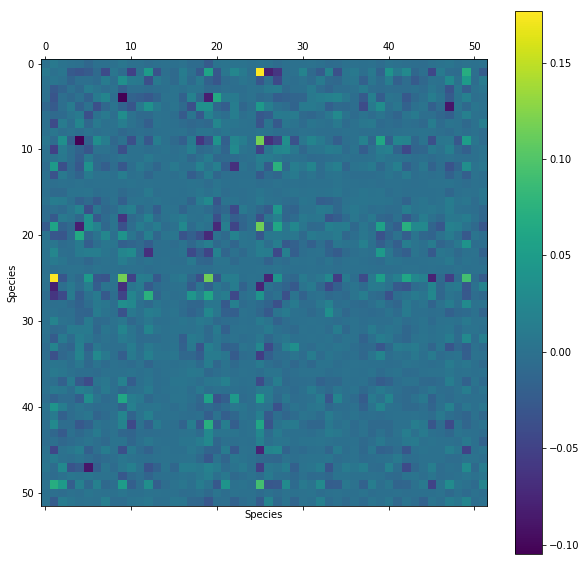

In [24]:
#plot the matrix M

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Species')
ax.set_ylabel('Species')
#ax.set_title('Matrix M')
pax=ax.matshow(M)
fig.colorbar(pax)
plt.show();

In [27]:
mean = np.mean(M.values.flatten())
var = np.var(M.values.flatten())
print('The mean is:'mean,'\n', 'The variance is: ',var)

The mean is: -0.0008827983258491153 
 The variance is:  0.00027805507210747855


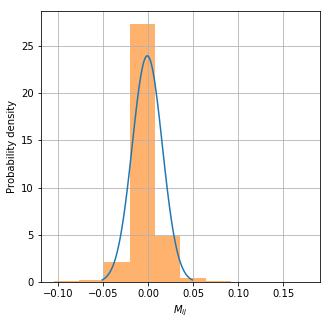

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
mu = np.mean(M.values.flatten())
variance = np.var(M.values.flatten())
sigma = ma.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.hist(M.values.flatten(),alpha=0.6,density=True)
ax.set_xlabel('$M_{ij}$')
ax.set_ylabel('Probability density')
ax.grid()

Computation of vector $\mu$: $$\mu=-M\langle x \rangle_{emp}$$

In [29]:
#vecl is vector lambda
vecl=-np.dot(M,abun_most['mean'])
vecl=pd.DataFrame(vecl, index=abun_most.index, columns=['Mu'])

print('The vector mu is')
vecl.T

The vector mu is


sp,ALSEBL,ANDIIN,BROSAL,CAPPFR,CASEAC,CHR2AR,CORDLA,CUPASY,DES2PA,ERY2MA,...,STYLST,SWARS1,SWARS2,TAB2AR,TACHVE,TALIPR,TET2PA,TRI2PA,TRI2TU,VIROSE
Mu,0.162728,0.346586,0.839548,0.203796,0.955041,0.817946,0.575322,0.311953,0.138114,0.67716,...,0.707613,0.188989,0.069695,0.365726,0.193765,0.883667,0.204686,0.254997,0.123074,0.542626


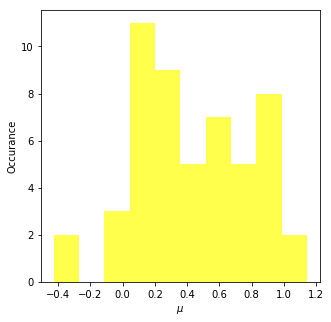

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(vecl.values,color='yellow',alpha=0.7)
ax.set_xlabel('$\mu$')
ax.set_ylabel('Occurance');

# Task 7

In [41]:
#definition of a function of the threshold theta for which M_ij=0 if |M_ij|<theta

def threshold(theta):
    Mt = M.copy()
    Mt[np.abs(Mt)<theta]=0
    return Mt

#definition of a function which compute the connected components of the graph

def connect(theta):
    Mt=threshold(theta)
    G=nx.Graph(Mt)
    return nx.number_connected_components(G)

In [42]:
#sorting the values of the matrix
Ms=M.values.reshape(len(M)*len(M),)
order=np.unique(np.sort(np.abs(Ms),))[::-1]

In [43]:
#look for theta*
theta_s=0
for theta in order:
    G=nx.Graph(threshold(theta))
    if nx.is_connected(G)==True:
        theta_s=theta
        print(nx.is_connected(G))
        break
        
print('Theta* is',theta_s)
print('The number of connected component with theta* is',connect(theta_s))

True
Theta* is 0.0032256317931810175
The number of connected component with theta* is 1


In [44]:
#plot theta
theta_plot=[]
for theta in order:
    theta_plot.append(connect(theta))
    

Text(0, 0.5, 'Number of connected components')

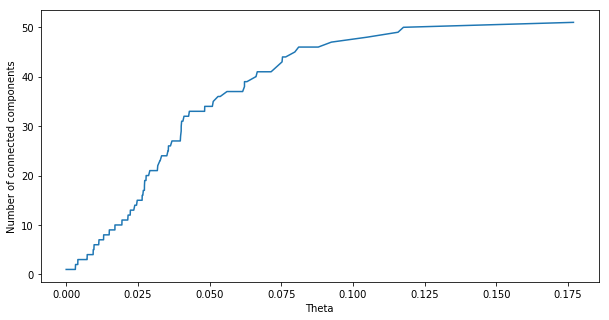

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(order, theta_plot)
ax.set_xlabel('Theta')
ax.set_ylabel('Number of connected components')

In [59]:
#definition of a function which compute properties of a network

def graph(G, lab, col='red'):   
    #plot of the graph
    fig, ax1 = plt.subplots(figsize=(8,8))
    nx.draw(G, node_color=col)
    
    #plot the graph properties
    fig2, ax2 = plt.subplots(figsize=(5,5))
    fig3, ax3 = plt.subplots(figsize=(5,5))
    fig4, ax4 = plt.subplots(figsize=(5,5))
    #degree of the graph
    #change string in int
    l=[]
    for i in np.array(G.degree())[:,1]:
        l.append(int(i))

    degree=pd.DataFrame(np.array(l),index=np.array(G.degree())[:,0], columns=['degree'])
    #plot of the degree distribution 
    
    ax2.hist(degree.values.reshape(len(degree),),histtype='barstacked',facecolor='b', alpha=0.75, label=lab)
    ax2.set_xlabel('Degree',fontsize=15)
    ax2.set_ylabel('Frequency',fontsize=15)
    ax2.legend()
    
    
    #average of the degree
    m_deg=degree['degree'].mean()
    
    #diameter of the graph
    diameter=nx.diameter(G)

    
    #clustering of the graph
    clustering=pd.DataFrame.from_dict(nx.algorithms.cluster.clustering(G), orient='index')

    #plot the clustering 
    ax3.hist(clustering.values.reshape(len(clustering),),histtype='barstacked',facecolor='g', alpha=0.75, label=lab)
    ax3.set_xlabel('Clustering',fontsize=15)
    ax3.set_ylabel('Frequency',fontsize=15)
    ax3.legend()
    
    #average of the clustering
    m_clu=clustering.mean(axis=0).values  
    
    #degree assorsativity
    d_ass=nx.degree_assortativity_coefficient(G)

    
    #betweenness centrality
    betweenness=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index')
   
    #plot the betweenness   
    ax4.hist(betweenness.values.reshape(len(betweenness),),histtype='barstacked',facecolor='r', alpha=0.75, label=lab)
    ax4.set_xlabel('Betweenness',fontsize=15)
    ax4.set_ylabel('Frequency',fontsize=15)
    ax4.legend()
    
    #average of the betweenness centrality
    m_bet=betweenness.mean(axis=0).values
    
    #summary
    summary=pd.DataFrame(np.array([nx.number_connected_components(G),G.number_of_edges(),G.number_of_nodes(),m_deg,diameter,m_clu,d_ass,m_bet]),index=['Connected components','Number of edges','Number of nodes','Mean degree','Diameter','Mean clustering','Degree assortativity','Mean betweenness centrality'],columns=['Values'])
    print(summary)

### W*

                                 Values
Connected components           1.000000
Number of edges              780.000000
Number of nodes               52.000000
Mean degree                   30.000000
Diameter                       3.000000
Mean clustering                0.727261
Degree assortativity          -0.251545
Mean betweenness centrality    0.008386


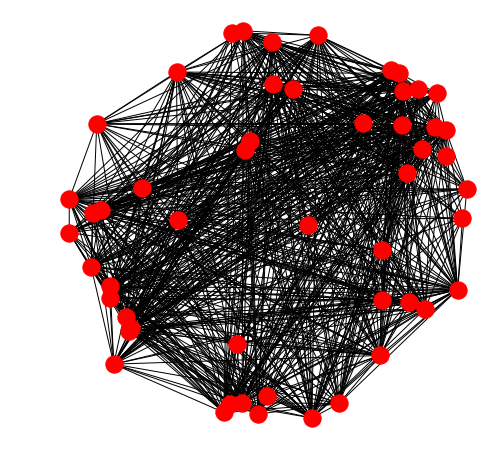

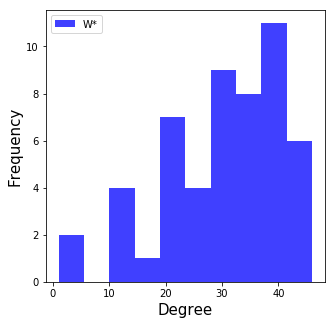

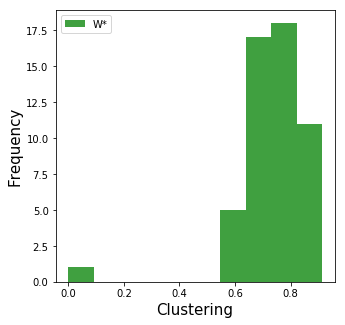

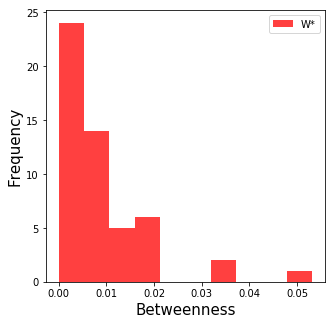

In [60]:
G=nx.Graph(threshold(theta_s))
graph(G, 'W*')

### Erdos - Renyi

                                 Values
Connected components           1.000000
Number of edges              789.000000
Number of nodes               52.000000
Mean degree                   30.346154
Diameter                       2.000000
Mean clustering                0.599384
Degree assortativity          -0.010116
Mean betweenness centrality    0.008100


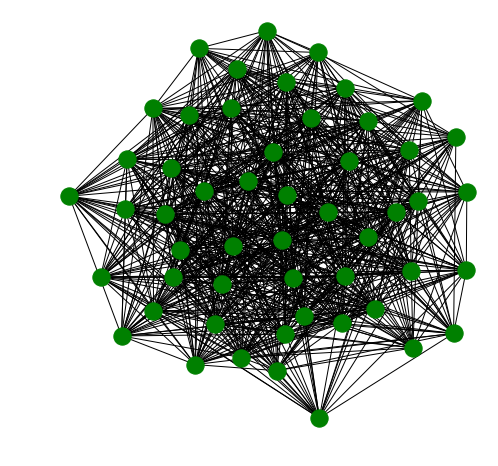

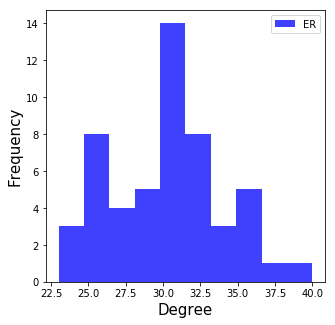

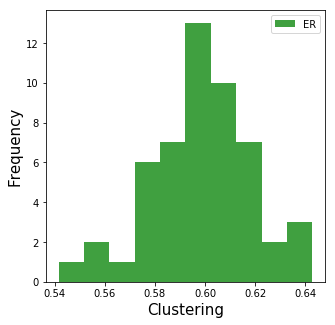

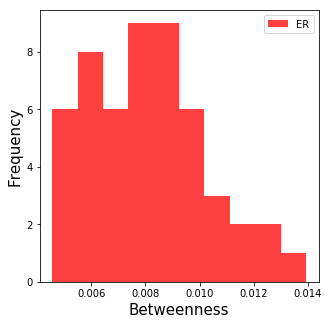

In [61]:
GER=nx.gnm_random_graph(52, 789)
graph(GER,'ER', 'green')